<a href="https://colab.research.google.com/github/anshuldutt21/KeystrokeDynamics-Model/blob/main/MLP_Keystroke_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Layer Perceptron Model

This file creates a **Multi Layer Perceptron** model. The generic MLP consists of four fully connected layers, in which the number of neurons are **512, 256, 144, and 51**, respectively. The output of the last layer is fed
into a softmax function to calculate the corresponding probability for each class. A Leaky rectified linear unit (Leakyrelu) activation function and a batch normalization layer are used in all the layers. 

In [ ]:
from google.colab import files
data = files.upload()

import pandas as pd

In [4]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing

# Mount drive and link to dataset
dataset = pd.read_excel('/content/drive/MyDrive/DSL-StrongPasswordData.xls')
X = dataset.iloc[:,3:].values
y = dataset.iloc[:,0].values

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
Y = np_utils.to_categorical(encoded_Y)

X = X.astype('float64')

X_test = X[200:400,:]
Y_test = Y[200:400,:]
X_train = X[0:180,:]
Y_train = Y[0:180,:]
X_val = X[180:200,:]
Y_val = Y[180:200,:]
X_final_train = X[0:200,:]
Y_final_train = Y[0:200,:]


for x in range(1,51):
  X_test = np.concatenate((X_test, X[200 + 400*x:400 + 400*x,:]), axis = 0)
  Y_test = np.concatenate((Y_test, Y[200 + 400*x:400 + 400*x,:]), axis = 0)
  
  X_train = np.concatenate((X_train, X[400*x:180 + 400*x,:]), axis = 0)
  Y_train = np.concatenate((Y_train, Y[400*x:180 + 400*x,:]), axis = 0)

  X_val = np.concatenate((X_val, X[180 + 400*x:200 + 400*x,:]), axis = 0)
  Y_val = np.concatenate((Y_val, Y[180 + 400*x:200 + 400*x,:]), axis = 0)

  X_final_train = np.concatenate((X_final_train, X[400*x:200 + 400*x,:]), axis = 0)
  Y_final_train = np.concatenate((Y_final_train, Y[400*x:200 + 400*x,:]), axis = 0)

layer = preprocessing.Normalization()
layer.adapt(X_final_train)
X_final_train = layer(X_final_train)

layer.adapt(X_test)
X_test = layer(X_test)

print(X_final_train.shape)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
(10200, 31)


The following code snippet increases the training dataset by 3 times by using data augmentation technique by randomly perturbing each timing feature based on a range of (−0.02, 0.02). 

In [ ]:
import pandas as pd
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.layers.experimental import preprocessing

dataset = pd.read_excel('/content/drive/MyDrive/DSL-StrongPasswordData.xls')
X = dataset.iloc[:,3:].values
y = dataset.iloc[:,0].values

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
Y = np_utils.to_categorical(encoded_Y)

X = X.astype('float64')

X_test = X[320:400,:]
Y_test = Y[320:400,:]
X_train = X[0:320,:]
Y_train = Y[0:320,:]


for x in range(1,51):
  X_test = np.concatenate((X_test, X[320 + 400*x:400 + 400*x,:]), axis = 0)
  Y_test = np.concatenate((Y_test, Y[320 + 400*x:400 + 400*x,:]), axis = 0)
  
  X_train = np.concatenate((X_train, X[400*x:320 + 400*x,:]), axis = 0)
  Y_train = np.concatenate((Y_train, Y[400*x:320 + 400*x,:]), axis = 0)

X_final_train = X_train
Y_final_train = Y_train

for train in range(len(X_train)):
  augmented_array = np.empty([2,31])

  for i in range(31):
    augmented_array[0, i] = random.randrange(-200,200)/10000
    augmented_array[1, i] = random.randrange(-200,200)/10000
  
  X_augmented_data = X_train[train,:] + augmented_array

  X_final_train = np.vstack([X_final_train, X_augmented_data[0,:]])
  Y_final_train = np.vstack([Y_final_train, Y[train,:]])
  X_final_train = np.vstack([X_final_train, X_augmented_data[1,:]])
  Y_final_train = np.vstack([Y_final_train, Y[train,:]])


X_final_train, Y_final_train = shuffle(X_final_train, Y_final_train)
layer = preprocessing.Normalization()
layer.adapt(X_final_train)
X_final_train = layer(X_final_train)

layer = preprocessing.Normalization()
layer.adapt(X_test)
X_test = layer(X_test)

print(X_final_train.shape)
print(X_test.shape)


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
(48960, 31)
(4080, 31)


The following code snippet divides the dataset into training and test dataset and is used for tuning the hyper parameters such as learning rate, optimization layers, number of neurons, etc.

In [ ]:
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from keras.layers import Dropout                       #for random dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold


leaky_relu_alpha = 0.01
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
batch_size_vals = [32]

model = Sequential()
model.add(Dense(512, kernel_initializer='glorot_uniform', bias_initializer='zeros', input_dim=31))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Dense(256, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(Dropout(0.50))

model.add(Dense(144, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Dense(51, activation='softmax'))
model.summary()

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])


# fit model
history = model.fit(X_final_train, Y_final_train, validation_data=(X_test, Y_test), epochs=200, batch_size = 32)

# evaluate the model
_, train_acc = model.evaluate(X_final_train, Y_final_train, verbose=0)
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

KeyboardInterrupt: ignored

The below code snippet uses 5 Fold Cross Validation to test the model on the basis of metrics such as accuracy, False Positives and Negatives, Precision and recall. 




tf.Tensor(
[[ 1.8832682   0.6546906   0.3685867  ...  0.12742025 -0.04127599
  -0.51478106]
 [ 0.6016322   0.39565718  0.2982988  ... -0.2066948  -0.15140903
  -0.49654943]
 [ 1.0670682  -0.1606759  -0.30579725 ... -0.31274182 -0.28278816
  -0.23766048]
 ...
 [ 0.02152329 -0.7140655  -0.6942803  ... -0.53459775 -0.5563864
   0.07956953]
 [-0.03244048 -0.6625532  -0.63681525 ... -0.578969   -0.5758982
   0.1743739 ]
 [-1.1353219  -0.6547037  -0.4739183  ... -0.54524684 -0.46836668
   0.49160418]], shape=(16320, 31), dtype=float32)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 512)               16384     
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_33 (Bat  (None, 512) 

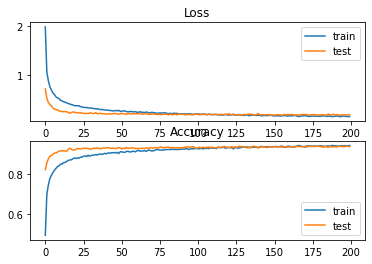

tf.Tensor(
[[ 0.595485    0.36260232  0.27563184 ... -0.20883268 -0.15207534
  -0.49584356]
 [ 1.3267859  -0.25573814 -0.42046207 ... -0.16790287 -0.22007625
   0.22802481]
 [ 1.202094   -0.05709789 -0.21111052 ...  0.00526123  0.05412109
  -0.2545541 ]
 ...
 [-0.94125855 -0.90232784 -0.75586075 ... -0.45621008 -0.65923077
   1.1529679 ]
 [-0.03808483 -0.60459167 -0.5831457  ... -0.58619565 -0.581578
   0.17684215]
 [-1.1400915  -0.5974173  -0.43354654 ... -0.55201256 -0.4727765
   0.49490574]], shape=(16320, 31), dtype=float32)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 512)               16384     
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_36 (Bat  (None, 512)     

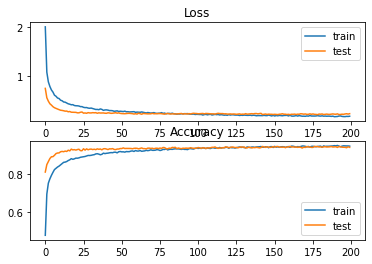

tf.Tensor(
[[ 1.8778322   0.5999525   0.34038022 ...  0.12541276 -0.04159015
  -0.50686663]
 [ 0.5968482   0.36318228  0.27586505 ... -0.20501648 -0.15045066
  -0.4886756 ]
 [ 1.3283572  -0.25520048 -0.41985244 ... -0.16508403 -0.21688128
   0.23168924]
 ...
 [-0.16837128 -0.87717074 -0.8309186  ... -0.51306593 -0.5224622
   0.6027863 ]
 [-0.94033265 -0.9018343  -0.75506973 ... -0.4463658  -0.6458946
   1.1521555 ]
 [ 0.01703441 -0.6511628  -0.6351936  ... -0.5293022  -0.5507488
   0.08616097]], shape=(16320, 31), dtype=float32)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 512)               16384     
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_39 (Bat  (None, 512)     

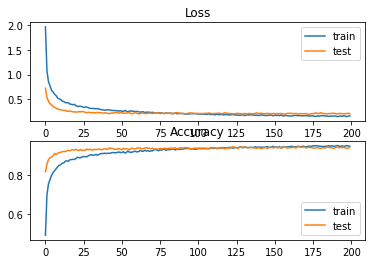

tf.Tensor(
[[ 1.8825557   0.59595174  0.34037548 ...  0.13460405 -0.03454661
  -0.5152864 ]
 [ 0.59726584  0.36210558  0.2765291  ... -0.19940548 -0.14469863
  -0.49707112]
 [ 1.3312339  -0.24864022 -0.41197658 ... -0.15904036 -0.21191737
   0.2242508 ]
 ...
 [ 0.01550304 -0.63971245 -0.6250855  ... -0.52720493 -0.54974586
   0.07852917]
 [-0.03861459 -0.59320897 -0.5728867  ... -0.5715621  -0.569261
   0.17324819]
 [-1.1446403  -0.58612275 -0.4249184  ... -0.5378506  -0.46171096
   0.4901929 ]], shape=(16320, 31), dtype=float32)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 512)               16384     
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_42 (Bat  (None, 512)    

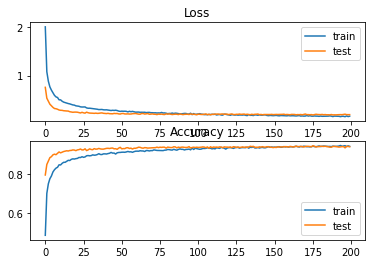

tf.Tensor(
[[ 1.8847706   0.5892721   0.33378386 ...  0.12730314 -0.04038865
  -0.5182765 ]
 [ 1.333555   -0.25377962 -0.4167572  ... -0.16581942 -0.21725841
   0.21879342]
 [ 1.2084323  -0.05793694 -0.21018626 ...  0.00465211  0.05301939
  -0.26048356]
 ...
 [ 0.01807781 -0.6441387  -0.6293531  ... -0.53332967 -0.5541327
   0.07355794]
 [-0.03602939 -0.59772    -0.57728004 ... -0.57760805 -0.57359266
   0.16796096]
 [-1.1418419  -0.5906467  -0.42966786 ... -0.54395646 -0.4663464
   0.48384827]], shape=(16320, 31), dtype=float32)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 512)               16384     
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_45 (Bat  (None, 512)    

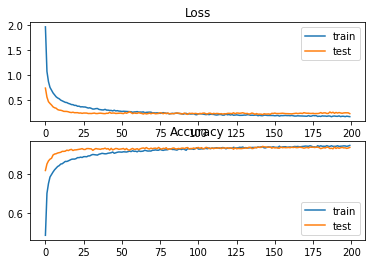

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.1994498074054718 - Accuracy: 94.11764740943909%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.21790798008441925 - Accuracy: 93.9460813999176%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.20778919756412506 - Accuracy: 94.19117569923401%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.19710171222686768 - Accuracy: 94.33823823928833%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.21902740001678467 - Accuracy: 93.89705657958984%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 94.09803986549377 (+- 0.16139371397462218)
> Loss: 0.20825521945953368
-----------------------

In [12]:
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from keras.layers import Dropout                       #for random dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold
import numpy as np

leaky_relu_alpha = 0.01
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
batch_size_vals = [32]
print("\n\n")
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
Xshape = X.shape
Yshape = Y.shape
initializer = keras.initializers.HeNormal()

for train, test in kfold.split(X, Y):
  Xtrain = np.empty(Xshape)
  Xtrain = Xtrain[0:0,:]
  
  Ytrain = np.empty(Yshape)
  Ytrain = Ytrain[0:0,:]
  
  Xtest = np.empty(Xshape)
  Xtest = Xtest[0:0,:]
  
  Ytest = np.empty(Yshape)
  Ytest = Ytest[0:0,:]

  for i in train:
    Xtrain = np.vstack([Xtrain, X[i,:]])
    Ytrain = np.vstack([Ytrain, Y[i,:]])

  for i in test:
    Xtest = np.vstack([Xtest, X[i,:]])
    Ytest = np.vstack([Ytest, Y[i,:]])

  layer = preprocessing.Normalization()
  layer.adapt(Xtrain)
  Xtrain = layer(Xtrain)

  layer.adapt(Xtest)
  Xtest = layer(Xtest)

  print(Xtrain)
  model = Sequential()
  model.add(Dense(512, kernel_initializer=initializer, bias_initializer='zeros', input_dim=31))
  model.add(LeakyReLU(alpha=leaky_relu_alpha))
  model.add(BatchNormalization())
  model.add(Dropout(0.30))

  model.add(Dense(256, kernel_initializer= initializer, bias_initializer='zeros'))
  model.add(LeakyReLU(alpha=leaky_relu_alpha))
  model.add(BatchNormalization())
  model.add(Dropout(0.50))

  model.add(Dense(144, kernel_initializer= initializer, bias_initializer='zeros'))
  model.add(LeakyReLU(alpha=leaky_relu_alpha))
  model.add(BatchNormalization())
  model.add(Dropout(0.30))

  model.add(Dense(51, activation='softmax'))
  model.summary()

  # Compile model
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy', keras.metrics.Precision(),keras.metrics.FalsePositives(), keras.metrics.FalseNegatives(), keras.metrics.Recall()])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # fit model
  history = model.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest), epochs=200, batch_size = 32)

  # evaluate the model
  # _, train_acc = model.evaluate(Xtrain, Ytrain, verbose=0)
  scores = model.evaluate(Xtest, Ytest, verbose=0)
  
  print(scores)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1

  # plot loss during training
  pyplot.subplot(211)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  print("\n\n")
  # plot accuracy during training
  pyplot.subplot(212)
  pyplot.title('Accuracy')
  pyplot.plot(history.history['accuracy'], label='train')
  pyplot.plot(history.history['val_accuracy'], label='test')
  pyplot.legend()
  pyplot.show()

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
